# Import the Packages

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # Plotting
import matplotlib.image as mpimg # image 
import seaborn as sns # Plotting
from tqdm import tqdm_notebook as tqdm
# Import Image Libraries - Pillow and OpenCd
# Import PyTorch and useful fuctions
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
# from imagaug import augmenters as iaa
import cv2
import PIL 
from PIL import Image, ImageOps
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torch.optim as optim
import torchvision.models as models # Pre-Trained models

# Import useful sklearn functions
import sklearn
from sklearn.metrics import cohen_kappa_score, accuracy_score

import time
from tqdm import tqdm_notebook


import skimage.io
import os,sys
import warnings
warnings.simplefilter("ignore")
print(os.listdir("../input"))
dir = '../input/aptos2019-blindness-detection/'

['resnet50', 'aptos2019-blindness-detection', 'prev-data-label']


# Loading Data

In [2]:
def read_data(dir,path):
    """
    input:
    dir(str): directory path 
    path(str): subpath of the file
    output:
    data(data_frame)
    """
    data_path = dir + str(path)
    data = pd.read_csv(data_path)
    return(data)

In [3]:
train_path = dir + 'train_images/'
test_path = dir + 'test_images/'

In [4]:
train = read_data(dir,"train.csv")
test = read_data(dir, "test.csv")
label = read_data(dir,'train.csv')

In [5]:
print('Train Size = {}'.format(len(train)))
print('Public Test Size = {}'.format(len(test)))

Train Size = 3662
Public Test Size = 1928


## Exploratory Data Analysis 

### Label Distribution 

In [6]:
def plot_label(data,label):
    """
    input:
    data(data_frame): the input dataframe 
    label(str): the labels to be plotted
    
    output:
    barplot of label distributions
    """
    labels = data[label].value_counts()
    class_list = ['No DR_0', 'Mild_1', 'Moderate_2', 'Severe_3', 'Proliferate_4']
    for idx,val in enumerate(class_list):
        labels[val] = labels.pop(idx)
    plt.figure(figsize = (10,5))
    sns.barplot(labels.index, labels.values, alpha = 0.8, palette = 'viridis_r')
    plt.title('Distribution of label classes')
    plt.ylabel("Number of occurrences", fontsize = 12)
    plt.xlabel("Target classes",fontsize = 12)
    plt.legend()
    plt.show()
    
def label_percentage(data, label):
    labels = pd.DataFrame(data[label].value_counts().sort_values(ascending = False))
    labels["percent"] = labels[label].apply(lambda x: 100*x / sum(labels[label].values))
    return (labels)

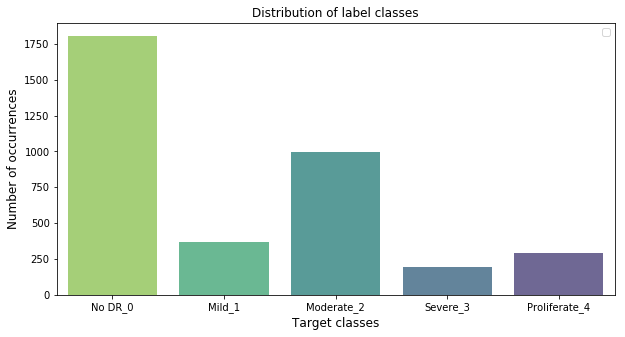

In [7]:
plot_label(train, "diagnosis")

In [8]:
label_percentage(train, "diagnosis")

,diagnosis,percent
0,1805,49.290005
2,999,27.280175
1,370,10.103768
4,295,8.055707
3,193,5.270344


We need to deal with the unbalanced class issue here, down sampling the the class 0 and upsampling the class 3. 

> ### Image Size Distribution Checking 

In [9]:
#the func is adapted from https://www.kaggle.com/toshik/image-size-and-rate-of-new-whale
def get_size_list(targets, path):
    """get the list of size of images.
    input: 
    targets(list): the list of target labels
    path(string):the path for the image address
    output:
    result(df): a data frame of image information
    """
    result = list()
    for target in tqdm(targets):
        img = np.array(Image.open(os.path.join(path, target + '.png')))
        result.append(img.shape)
    return result

# the func is from https://www.kaggle.com/kaerunantoka/extract-image-features
def get_size(file_name_list, path):
    result = list()
    for file_name in tqdm(file_name_list):
        st = os.stat(f'{path}/{file_name}.png')
        # get the size of image in bit 
        result.append(st.st_size)
    return result

In [10]:
train['image_shape'] = get_size_list(train.id_code.tolist(), train_path)
test['image_shape'] = get_size_list(test.id_code.tolist(),test_path)
train['image_size'] = get_size(train.id_code.tolist(), train_path)
test['image_size'] = get_size(test.id_code.tolist(), test_path)


In [11]:
for df in [train, test]:
    df["height"] = df["image_shape"].apply(lambda x:x[0])
    df["width"] = df["image_shape"].apply(lambda x:x[1])
    df["width_height_ratio"] = df["height"]/df["width"]

In [12]:
train.tail(20)

,id_code,diagnosis,image_shape,image_size,height,width,width_height_ratio
3642,fecf4c5ae84b,1,"(1736, 2416, 3)",1704075,1736,2416,0.718543
3643,fed5bb685832,0,"(1050, 1050, 3)",1033170,1050,1050,1.000000
3644,fefded6bf135,0,"(1958, 2588, 3)",5164299,1958,2588,0.756569
3645,ff03f74667df,0,"(1536, 2048, 3)",1910238,1536,2048,0.750000
3646,ff0740cb484a,2,"(1000, 1504, 3)",1332868,1000,1504,0.664894
3647,ff1e940105f9,0,"(1050, 1050, 3)",949217,1050,1050,1.000000
3648,ff344e5c9341,2,"(2136, 3216, 3)",2250953,2136,3216,0.664179
3649,ff4832d55461,0,"(1536, 2048, 3)",1804739,1536,2048,0.750000
3650,ff4955e76894,0,"(1736, 2416, 3)",2333015,1736,2416,0.718543
3651,ff4cd992667b,0,"(1958, 2588, 3)",5348220,1958,2588,0.756569


In [13]:
test.head(20)

,id_code,image_shape,image_size,height,width,width_height_ratio
0,0005cfc8afb6,"(480, 640, 3)",236005,480,640,0.750000
1,003f0afdcd15,"(480, 640, 3)",212295,480,640,0.750000
2,006efc72b638,"(480, 640, 3)",202491,480,640,0.750000
3,00836aaacf06,"(480, 640, 3)",234517,480,640,0.750000
4,009245722fa4,"(480, 640, 3)",246856,480,640,0.750000
5,009c019a7309,"(480, 640, 3)",226380,480,640,0.750000
6,010d915e229a,"(1736, 2416, 3)",2240876,1736,2416,0.718543
7,0111b949947e,"(1050, 1050, 3)",948707,1050,1050,1.000000
8,01499815e469,"(480, 640, 3)",229826,480,640,0.750000
9,0167076e7089,"(480, 640, 3)",227529,480,640,0.750000


## Data Visualization

In [14]:
def show_image(path,data,nbr,if_train = True):
    """
    input: 
    path(string):the path for the image address
    data(data_frame): the input dataframe 
    nbr(int):the number of images sampled from each label
    if_train(boolean): default = True; if False, then show test images.
    
    output:
    arrayed images sampled from all classes 
    """
    fig = plt.figure(figsize=(25, 16))
    imgs= os.listdir(path)
    if if_train:
        for class_id in sorted(data['diagnosis'].unique()):
            for i, (idx, img) in enumerate(data.loc[data['diagnosis'] == class_id].sample(nbr).iterrows()):
                a = len(data['diagnosis'].unique())
                ax = fig.add_subplot(a, nbr, class_id * nbr + i + 1, xticks=[], yticks=[])
                im = Image.open(path + img['id_code'] + ".png")
                plt.imshow(im)
                ax.set_title(f'Label: {class_id}')
    else:
        for idx,img in enumerate(data.sample(nbr).iterrows()):
            ax = fig.add_subplot(2, nbr//2, idx+1)
            image = Image.open(path + img[1][0] + ".png")
            plt.imshow(image)
            ax.set_title('image_{}'.format(img[1][0]))

# Visualizing Train Set

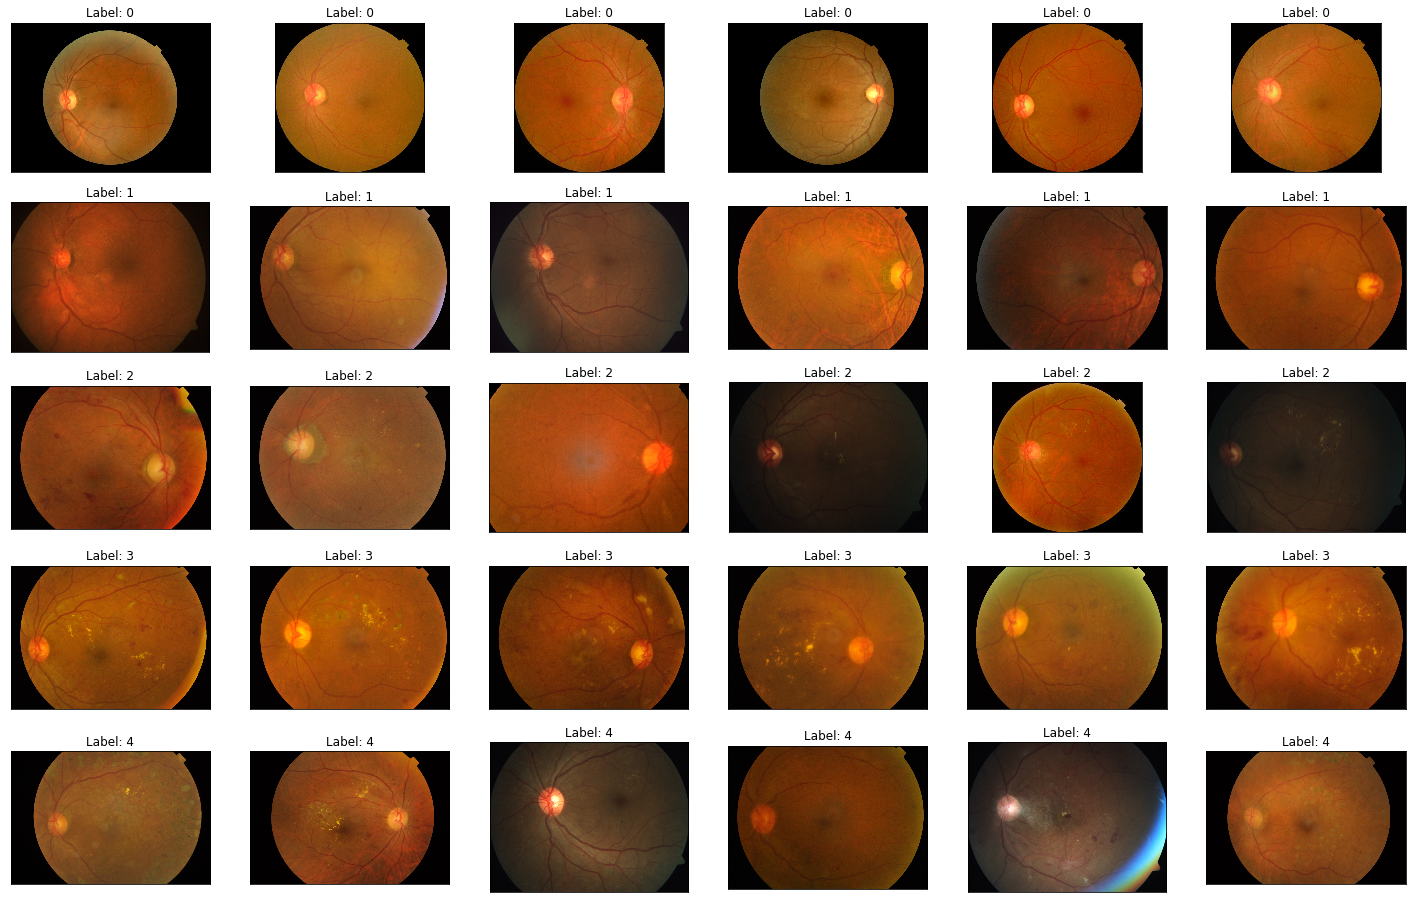

In [15]:
nbr = 6
img_show = show_image(train_path, train, nbr)

cotton wool and hard exudus are easier to find. Hermorrages and aneursym are hard to identify. 

## Visualizing Test Set 

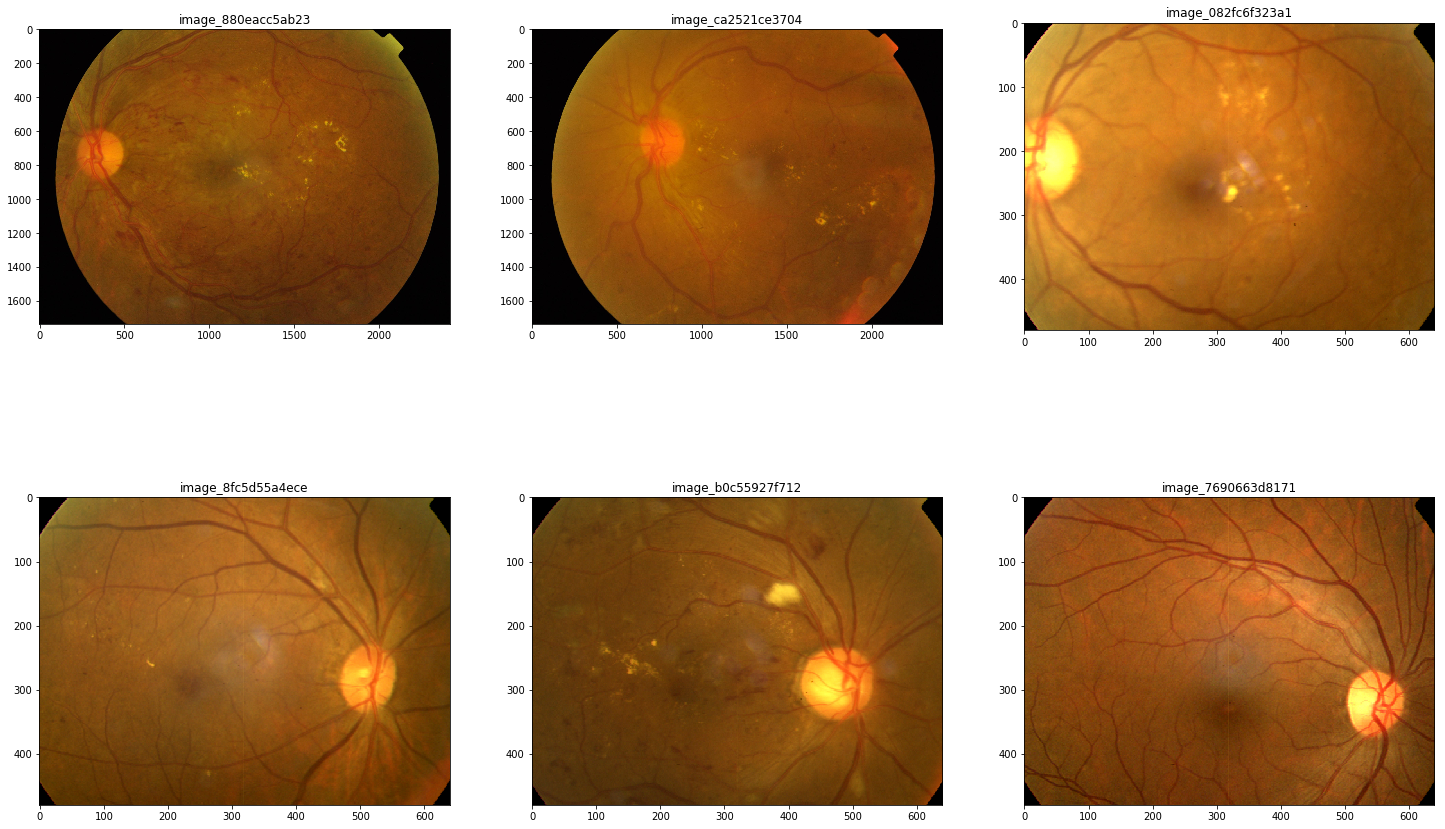

In [16]:
nbr = 6
img_show = show_image(test_path,test, nbr,if_train= False)

## Visualizing One Image 

In [17]:
def single_image(path,image_code, dpi = 100,scale = 2):
    """
    input:
    dpi(int): controls the pixel dimension printed per inch(default = 100)
    path(str):the path of the file 
    image_code(str): the id_code of the iamge 
    scale(int):control the image size when scaled(default = 2)
    
    output:
    processed iamge 
    
    """
    dpi = dpi 
    path = path + image_code + ".png"
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    height, width = image.shape
    print("the size of the image is ({}, {})".format(height,width))

    SCALE= scale
    figsize = (width / float(dpi))/SCALE, (height / float(dpi))/SCALE

    fig = plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')

the size of the image is (1226, 1844)


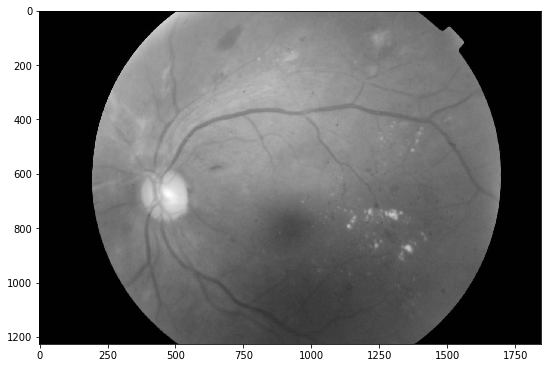

In [18]:
single_image(path = train_path, image_code = "ff8a0b45c789")

Conclusions:
- Finding_1: Highly imbalanced distribution of the target are found and need to be addressed before modeling. We need to downsampling the level 0 and upsampling level 1, 3 and 4. If more data samples could be found to supplement level 1, 3, 4.  
- Finding_2: From the EDA process above, we barely see through eyes the difference between four levels of symptoms. 
    -- Between level 0 to level 4,the cotton wool and hard exudus are easier to find. Hermorrages and aneursym are hard to identify. 
- Finding_3: The symptom could be seen with larger and higher resoluted image
- Finding_4: A large variety of image size across different classes
- Possible ways to augment the image: <br>
  1) adjust image size <br>
  2) adjust image lighting/contrast <br>
  3) adjust the color 

Reference and Credit to: <br>
1) https://www.kaggle.com/tanlikesmath/intro-aptos-diabetic-retinopathy-eda-starter <br>
2) https://www.kaggle.com/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy <br>
3) https://www.kaggle.com/yangsaewon/basic-eda-train-test-image-distribution-check <br>
